In [216]:
# Install the python-chess package with version 0.31.3
!pip install python-chess==0.31.3

# Install the pydot package
!pip install pydot

In [217]:
import chess
import chess.engine
import random
import numpy

# Define the function to generate a random chess board
def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(20, max_depth)
    
    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        
        # Check if the game is over
        if board.is_game_over():
            break
    
    # Return the resulting chess board object
    return board

# Define the function to evaluate a chess position using Stockfish
def stockfish(board, depth):
    with chess.engine.SimpleEngine.popen_uci('/content/stockfish') as sf:
        result = sf.analyse(board, chess.engine.Limit(depth=depth))
        score = result['score'].white().score()
        return score

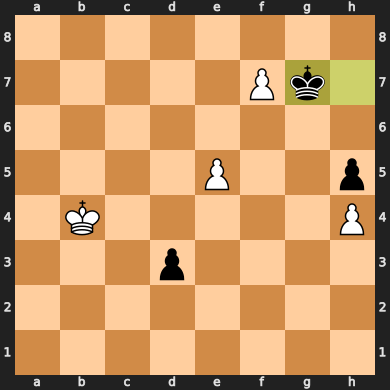

In [218]:
board = random_board()
board

In [219]:
# print(stockfish(board,10))

In [220]:
# Define a dictionary to map chess square names to their corresponding indices in the board3d array
square_index ={
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7 
}

# Define a function to convert a chess square to its corresponding indices in the board3d array
def square_to_index(square):
    # Get the letter and number of the square name
    letter = chess.square_name(square)
    # Compute the row and column indices in the board3d array
    return 8 - int(letter[1]), square_index[letter[0]]

# Define a function to split the board into 14 layers (one for each piece type, two for legal moves, and one for whose turn it is)
def split_dims(board):
    # Initialize a 3D numpy array to represent the board
    board3d = numpy.zeros((14,8,8), dtype = numpy.int8)
    
    # Loop over each piece type
    for piece in chess.PIECE_TYPES:
        # Loop over each white piece of the current type
        for square in board.pieces(piece, chess.WHITE):
            # Get the row and column indices in the board3d array for the current square
            idx = numpy.unravel_index(square,(8,8))
            # Set the corresponding element in the board3d array to 1
            board3d[piece-1][7-idx[0]][idx[1]] = 1
        # Loop over each black piece of the current type
        for square in board.pieces(piece, chess.BLACK):
            # Get the row and column indices in the board3d array for the current square
            idx = numpy.unravel_index(square, (8,8))
            # Set the corresponding element in the board3d array to 1
            board3d[piece +5][7-idx[0]][idx[1]] = 1
        
        # Save the current turn, and temporarily set it to white to generate legal moves for white
        aux = board.turn
        board.turn = chess.WHITE
        # Loop over each legal move for white
        for move in board.legal_moves:
            # Get the row and column indices in the board3d array for the destination square of the current move
            i, j = square_to_index(move.to_square)
            # Set the corresponding element in the board3d array to 1
            board3d[12][i][j] = 1
        # Set the turn back to the original value
        board.turn = chess.BLACK
        # Loop over each legal move for black
        for move in board.legal_moves:
            # Get the row and column indices in the board3d array for the destination square of the current move
            i, j = square_to_index(move.to_square)
            # Set the corresponding element in the board3d array to 1
            board3d[13][i][j] = 1
        # Set the turn back to the original value
        board.turn = aux
        
    # Return the final board3d array
    return board3d

In [221]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [222]:
# Import necessary modules from Keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

# Define a function to build a convolutional neural network model for the chess board
def build_model(conv_size, conv_depth):
    # Define an input layer with shape (14, 8, 8) to represent the 14-layered chess board
    board3d = layers.Input(shape=(14,8,8))
    
    # Apply multiple convolutional layers to extract features from the board
    x = board3d
    for _ in range(conv_depth):
        # Use a 3x3 kernel with ReLU activation and same padding
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation ='relu')(x)
    
    # Flatten the feature maps and apply fully connected layers to predict the game outcome
    x = layers.Flatten()(x)
    x = layers.Dense(64, 'relu')(x)
    x = layers.Dense(1, 'sigmoid')(x)
    
    # Create a Keras model with the input layer and output layer
    return models.Model(inputs=board3d, outputs=x)


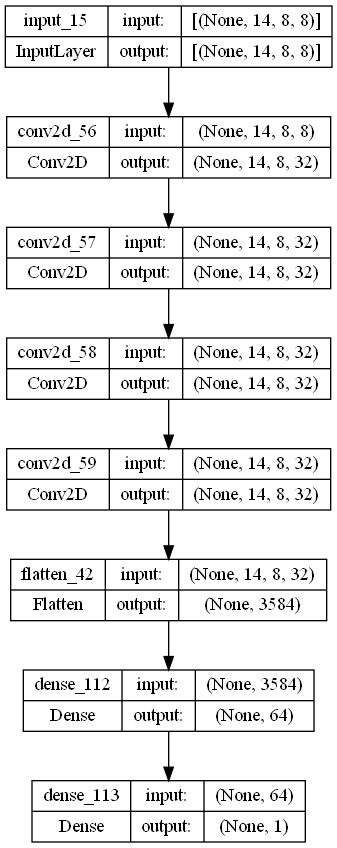

In [223]:
# Build a model with 32 filters per convolutional layer and 4 convolutional layers
model = build_model(32, 4)

# Use the plot_model function from Keras to create a visualization of the model architecture
# The resulting plot will be saved as 'model_plot.png' in the current directory
# show_shapes=True displays the shape of each layer in the plot
# show_layer_names=True displays the name of each layer in the plot
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [224]:
import tensorflow.keras.callbacks as callbacks
import pandas as pd
import numpy as np

def get_dataset():
    # Read the dataset from CSV file
    dataset = pd.read_csv("games.csv")
    
    # Extract relevant columns
    moves = dataset['board']
    result = dataset['v1']
    white_rating = dataset['white_rating']
    black_rating = dataset['black_rating']
    
    # Calculate b and v values
    b = np.where(result == 'white', white_rating - black_rating, black_rating - white_rating)
    v = np.where(b > 0, b / white_rating.max(), -b / black_rating.max())  # Normalize to [-1, 1]
    
    return moves, v

# Load the dataset and split it into input features (moves) and target values (v)
x_train, y_train = get_dataset()

# Print the shapes of the input and target arrays
print(x_train.shape)  # should output (n_samples,)
print(y_train.shape)  # should output (n_samples,)

(20035,)
(20035,)


In [225]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Read the dataset from CSV file and preprocess the data
def get_dataset():
    dataset = pd.read_csv("games.csv")
    
    # Extract relevant columns
    moves = dataset['board']
    result = dataset['v1']
    white_rating = dataset['white_rating']
    black_rating = dataset['black_rating']
    
    # Calculate b and v values
    b = np.where(result == 'white', white_rating - black_rating, black_rating - white_rating)
    v = np.where(b > 0, b / white_rating.max(), -b / black_rating.max())  # Normalize to [-1, 1]
    
    return moves, v

# Load and preprocess the dataset
x_train_raw, y_train = get_dataset()

# Process the moves data
def process_moves(moves):
    processed_moves = []
    
    for move_sequence in moves:
        move_list = move_sequence.split()
        # Perform your preprocessing logic here to convert moves into a suitable format
        processed_moves.append(move_list)
    
    return processed_moves

x_train = process_moves(x_train_raw)

# Convert the moves to numerical representation
# Implement your own logic here to convert moves to a suitable format
# Example: one-hot encoding of the moves
all_moves = []
for moves in x_train:
    all_moves.extend(moves)
unique_moves = list(set(all_moves))

# Create a mapping of moves to numerical values
move_to_numeric = {move: i for i, move in enumerate(unique_moves)}
numeric_moves = []
for moves in x_train:
    numeric_moves.append([move_to_numeric[move] for move in moves])

# Determine the maximum number of moves in a game
max_moves = max(len(moves) for moves in numeric_moves)

# Pad the sequences to have the same length
x_train_processed = tf.keras.preprocessing.sequence.pad_sequences(numeric_moves, maxlen=max_moves)

# Create the AI model
model = keras.Sequential([
    layers.Embedding(input_dim=len(unique_moves), output_dim=16, input_length=max_moves),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train_processed, y_train, epochs=10, batch_size=32)

# Save the trained model
model.save("chess_ai_model.h5")

Epoch 1/10
627/627 [==============================] - 6s 8ms/step - loss: 0.0045
Epoch 2/10
627/627 [==============================] - 6s 9ms/step - loss: 0.0038
Epoch 3/10
627/627 [==============================] - 6s 9ms/step - loss: 0.0029
Epoch 4/10
627/627 [==============================] - 5s 8ms/step - loss: 0.0020
Epoch 5/10
627/627 [==============================] - 6s 9ms/step - loss: 0.0015
Epoch 6/10
627/627 [==============================] - 6s 9ms/step - loss: 0.0014
Epoch 7/10
627/627 [==============================] - 5s 8ms/step - loss: 9.6607e-04
Epoch 8/10
627/627 [==============================] - 6s 9ms/step - loss: 8.5043e-04
Epoch 9/10
627/627 [==============================] - 6s 9ms/step - loss: 8.3478e-04
Epoch 10/10
627/627 [==============================] - 5s 9ms/step - loss: 6.7984e-04


In [226]:
# Display the model summary
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 349, 16)           71104     
                                                                 
 flatten_43 (Flatten)        (None, 5584)              0         
                                                                 
 dense_114 (Dense)           (None, 128)               714880    
                                                                 
 dense_115 (Dense)           (None, 64)                8256      
                                                                 
 dense_116 (Dense)           (None, 1)                 65        
                                                                 
Total params: 794,305
Trainable params: 794,305
Non-trainable params: 0
_________________________________________________________________


In [227]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Read the dataset from CSV file and preprocess the data
def get_dataset():
    dataset = pd.read_csv("games.csv")
    
    # Extract relevant columns
    moves = dataset['board']
    result = dataset['v1']
    white_rating = dataset['white_rating']
    black_rating = dataset['black_rating']
    
    # Calculate b and v values
    b = np.where(result == 'white', white_rating - black_rating, black_rating - white_rating)
    v = np.where(b > 0, b / white_rating.max(), -b / black_rating.max())  # Normalize to [-1, 1]
    
    return moves, v

# Load and preprocess the dataset
x_train_raw, y_train = get_dataset()

# Process the moves data
def process_moves(moves):
    processed_moves = []
    
    for move_sequence in moves:
        move_list = move_sequence.split()
        # Perform your preprocessing logic here to convert moves into a suitable format
        processed_moves.append(move_list)
    
    return processed_moves

x_train = process_moves(x_train_raw)

# Convert the moves to numerical representation
# Implement your own logic here to convert moves to a suitable format
# Example: one-hot encoding of the moves
all_moves = []
for moves in x_train:
    all_moves.extend(moves)
unique_moves = list(set(all_moves))

# Create a mapping of moves to numerical values
move_to_numeric = {move: i for i, move in enumerate(unique_moves)}
numeric_moves = []
for moves in x_train:
    numeric_moves.append([move_to_numeric[move] for move in moves])

# Determine the maximum number of moves in a game
max_moves = max(len(moves) for moves in numeric_moves)

# Pad the sequences to have the same length
x_train_processed = tf.keras.preprocessing.sequence.pad_sequences(numeric_moves, maxlen=max_moves)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_processed, y_train, test_size=0.2, random_state=42)

# Create the AI model
model = keras.Sequential([
    layers.Embedding(input_dim=len(unique_moves), output_dim=16, input_length=max_moves),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the testing set
loss = model.evaluate(x_test, y_test)

# Save the trained model
model.save("chess_ai_model.h5")

# Display the model summary
model.summary()

Epoch 1/10
501/501 [==============================] - 6s 9ms/step - loss: 0.0047
Epoch 2/10
501/501 [==============================] - 4s 8ms/step - loss: 0.0041
Epoch 3/10
501/501 [==============================] - 4s 9ms/step - loss: 0.0028
Epoch 4/10
501/501 [==============================] - 5s 9ms/step - loss: 0.0018
Epoch 5/10
501/501 [==============================] - 5s 9ms/step - loss: 0.0014
Epoch 6/10
501/501 [==============================] - 4s 8ms/step - loss: 0.0012
Epoch 7/10
501/501 [==============================] - 5s 9ms/step - loss: 0.0010
Epoch 8/10
501/501 [==============================] - 5s 9ms/step - loss: 9.2367e-04
Epoch 9/10
501/501 [==============================] - 4s 9ms/step - loss: 7.0050e-04
Epoch 10/10
126/126 [==============================] - 1s 5ms/step - loss: 0.0062
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding) 

Welcome to the Chess AI!
Enter your moves below. Enter 'q' to quit.
Your move: e4
1/1 [==============================] - 0s 116ms/step


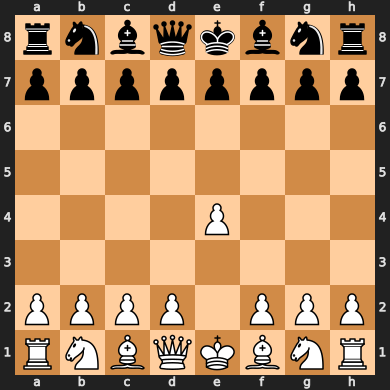

Predicted outcome: White
Your move: e4
1/1 [==============================] - 0s 26ms/step
Invalid move. Please try again.
Your move: d2
1/1 [==============================] - 0s 34ms/step
Invalid move. Please try again.
Your move: c3
1/1 [==============================] - 0s 23ms/step
Invalid move. Please try again.
Your move: d5
1/1 [==============================] - 0s 26ms/step


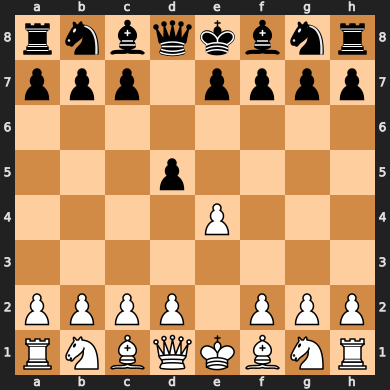

Predicted outcome: White
Your move: c3
1/1 [==============================] - 0s 35ms/step


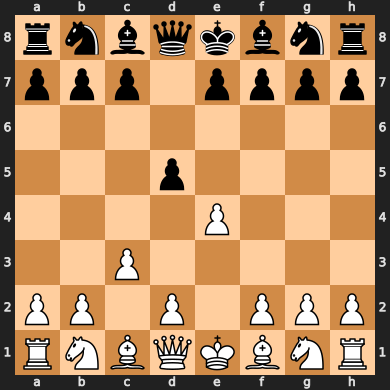

Predicted outcome: White
Your move: d6
1/1 [==============================] - 0s 24ms/step
Invalid move. Please try again.


In [ ]:
# Human Vs Model.
import numpy as np
import tensorflow as tf
from tensorflow import keras
import chess
import chess.svg
from IPython.display import SVG, display

# Load the trained model
model = keras.models.load_model("chess_ai_model.h5")

# Convert moves to numerical representation using the same preprocessing logic
def preprocess_moves(moves, unique_moves, move_to_numeric, max_moves):
    processed_moves = moves.split()
    numeric_moves = [move_to_numeric[move] for move in processed_moves]
    padded_moves = tf.keras.preprocessing.sequence.pad_sequences([numeric_moves], maxlen=max_moves)
    return padded_moves

# Define a function to play with the AI model
def play_with_model(model, unique_moves, move_to_numeric, max_moves):
    print("Welcome to the Chess AI!")
    print("Enter your moves below. Enter 'q' to quit.")
    moves = ""
    board = chess.Board()

    while True:
        move = input("Your move: ")
        if move == 'q':
            break

        moves += move + " "
        
        # Preprocess the moves
        padded_moves = preprocess_moves(moves, unique_moves, move_to_numeric, max_moves)
        
        # Make predictions using the model
        predictions = model.predict(padded_moves)
        
        # Determine the predicted outcome
        outcome = "White" if predictions[0][0] > 0 else "Black"
        
        # Update the chess board and display it
        try:
            board.push_san(move)
            display(SVG(chess.svg.board(board=board)))
            print(f"Predicted outcome: {outcome}")
        except ValueError:
            print("Invalid move. Please try again.")
            continue

# Call the function to play with the AI model
play_with_model(model, unique_moves, move_to_numeric, max_moves)

In [ ]:
import numpy

def minimax_eval(board):
    board3d = split_dims(board)
    board3d = numpy.expand_dims(board3d, 0)
    return model.predict(board3d)[0][0]

def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minimax_eval(board)
    
    if maximizing_player:
        max_eval = -numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval
            
            
def get_ai_move(board, depth):
    max_move = None
    max_eval = -numpy.inf
    
    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            max_move = move
                
    return max_move

In [ ]:
board = chess.Board()


    while True:
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            break